# Tuning Haiku hyperparameters via Optuna

## Data Setup

In [7]:
# Commands needed in colab
!pip install dm-haiku
!pip install torchaudio
!pip install optuna
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sns
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import jax.numpy as jnp
import jax
from jax import jit, grad, random
from jax.experimental import optimizers
import haiku as hk
from tqdm.autonotebook import tqdm
import time
import torchaudio
from torchaudio.transforms import Spectrogram
from importlib import reload
from pathlib import Path
import optuna
%matplotlib inline

In [2]:
esc50_path = 'data/ESC-50-master/audio'

Define a pytorch dataset able to load numpy files: remember that, because of the function load_hf, preprocessed data are stored in 6 .npy files called x_train, x_val, x_test, y_train, y_val, y_test.

In [3]:
class ESC50_DataGenerator(Dataset):
    
    def __init__(self, path, kind='train', transform=None):
        
        if kind=='train':
            files = Path(path).glob('[1-3]-*')
        if kind=='val':
            files = Path(path).glob('4-*')
        if kind=='test':
            files = Path(path).glob('5-*')
        
        self.items = [(str(file), file.name.split('-')[-1].replace('.wav', '')) for file in files]
        self.length = len(self.items)
        self.transform = transform
        
    def __len__(self):
        return self.length
    
    def __getitem__(self, index):
        filename, label = self.items[index]
        data_tensor, rate = torchaudio.load(filename)
        
        sample = (data_tensor.numpy(), int(label))
        if self.transform is not None:
            sample = self.transform(sample)
        
        return sample

In [ ]:
spec_list = []
label_list = []

for filename, label in tqdm(ESC50_DataGenerator(esc50_path, kind='train').items):

    data_tensor, _ = torchaudio.load(filename)
    spectrogram = Spectrogram(n_fft = 600, 
                              win_length = None, 
                              power = None,
                              normalized = True, 
                              return_complex = True)(data_tensor)

    spec_list.append(spectrogram)
    label_list.append(int(label))

In [ ]:
train_data = torch.stack(spec_list, axis=0).numpy()
train_labels = np.stack(label_list).astype(int)

In [ ]:
with open('drive/MyDrive/ESC-50-Spectrograms/train_data.npy', 'wb') as f:
    np.save(f, train_data)
    
with open('drive/MyDrive/ESC-50-Spectrograms/train_labels.npy', 'wb') as f:
    np.save(f, train_labels)

Define also some transformations that can be useful when loading input data.

In [12]:
class ToTensor_onehot(object):
    """Convert sample to Tensors."""
    def __init__(self, n_classes=2):
        self.n_classes = n_classes

    def __call__(self, sample):
        x, y = sample
        #if y == 2:
        #  y = 1
        # One-hot encoding
        y = np.eye(self.n_classes)[y]
        return ( torch.from_numpy(x), torch.tensor([y]) )
    
class Squeeze(object):
    """Remove the extra dimensions of the tensors."""
    def __init__(self, squeeze_x=True, squeeze_y=True):
        self.squeeze_x = squeeze_x
        self.squeeze_y = squeeze_y
    
    def __call__(self, sample):
        x, y = sample
        if self.squeeze_x:
            x = torch.squeeze(x)
        if self.squeeze_y:
            y = torch.squeeze(y)
        return ( x, y )
    
class Generate_Spectrograms(object):
    def __call__(self, sample):
        x, y = sample
        spectrogram = Spectrogram(n_fft = 600, 
                                  win_length = None, 
                                  power = None,
                                  normalized = True, 
                                  return_complex = True)(x)
        return (spectrogram, y)

In [13]:
def build_dataloaders(data_dir, composed_transform, batch_size=32):
    
    train_dataloader = DataLoader(ESC50_DataGenerator(path = data_dir,
                                                      kind = 'train',
                                                      transform=composed_transform),
                                  batch_size=batch_size, shuffle=True)

    validation_dataloader = DataLoader(ESC50_DataGenerator(path = data_dir,
                                                      kind = 'val',
                                                      transform=composed_transform),
                                  batch_size=batch_size, shuffle=True)

    test_dataloader = DataLoader(ESC50_DataGenerator(path = data_dir,
                                                      kind = 'test',
                                                      transform=composed_transform),
                                  batch_size=batch_size, shuffle=True)
    
    return train_dataloader, validation_dataloader, test_dataloader

In [14]:
data_dir = esc50_path
batch_size = 32

In [15]:
transform_to_spec = transforms.Compose([ToTensor_onehot(n_classes=50), Squeeze(squeeze_x=False), Generate_Spectrograms()])
train_dl, val_dl, test_dl = build_dataloaders(data_dir, transform_to_spec, batch_size=batch_size)

batch_sample = next(iter(train_dl))
print('Data shapes:\n x-> {} y-> {}'.format(batch_sample[0].shape, batch_sample[1].shape))
print('\nNumber of samples in the datasets: \n  Training set: {0} \n  Validation set: {1} \n  Test set: {2}'.format(len(train_dl)*batch_size, len(val_dl)*batch_size, len(test_dl)*batch_size))

Data shapes:
 x-> torch.Size([32, 1, 301, 736]) y-> torch.Size([32, 50])

Number of samples in the datasets: 
  Training set: 1216 
  Validation set: 416 
  Test set: 416


In [18]:
from complex_nn.layers import Cmplx_Conv2D, Cmplx_Linear, CmplxBatchNorm, Dropout
from complex_nn.activations import cardioid
from complex_nn.optimizers import cmplx_adam
from complex_nn.Classifier_wrapper import Haiku_Classifier

In [21]:
from complex_nn.haiku_ml_utils import haiku_check_model_parameters

In [22]:
class final_CNN(hk.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = Cmplx_Conv2D(4, kernel_shape=3, stride=2, data_format='NCHW')
        self.conv2 = Cmplx_Conv2D(8, kernel_shape=3, stride=2, data_format='NCHW')
        self.conv3 = Cmplx_Conv2D(16, kernel_shape=3, stride=2, data_format='NCHW')

        self.flatten = hk.Flatten()
        
        self.avg_pool = hk.AvgPool(window_shape=3, strides=2, padding='SAME', channel_axis=1)

        self.fc1 = Cmplx_Linear(256)
        self.fc2 = Cmplx_Linear(128)
        self.fc3 = Cmplx_Linear(50)

        self.dropout = Dropout(0.3)
        
        self.batchnorm_2D = CmplxBatchNorm(create_scale=True, create_offset=True, decay_rate=0.9, data_format='NCHW')
        self.batchnorm_1D = CmplxBatchNorm(create_scale=True, create_offset=True, decay_rate=0.9, data_format='NC')
        
        self.act = cardioid

    def __call__(self, z, is_training):
        z = self.act(self.conv1(z))
        z = self.batchnorm_2D(z, is_training)
        z = self.dropout(z, is_training)
        z = self.act(self.conv2(z))
        z = self.avg_pool(z)
        z = self.act(self.conv3(z))
        z = self.avg_pool(z)

        z = self.flatten(z)
        z = self.act(self.fc1(z))
        z = self.batchnorm_1D(z, is_training)
        z = self.dropout(z, is_training)
        z = self.act(self.fc2(z))
        z = self.dropout(z, is_training)
        z = self.fc3(z)
        
        return z

def _finalforward(x, is_training):
    net = final_CNN()
    return net(x, is_training)

In [24]:
haiku_check_model_parameters(final_CNN, init_shape=(32, 1, 301, 736), data_type=np.csingle, verbose=False)

Total number of parameters in the model: 984486
Parameters' dtype: complex64


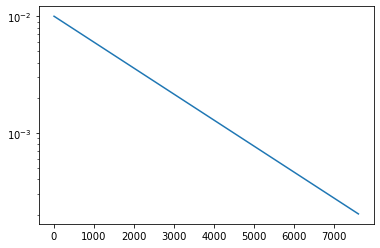

In [75]:
step_size = 0.01
decay_steps = 100
decay_rate = 0.95

lr_scheduler = jax.experimental.optimizers.exponential_decay(step_size=step_size, decay_steps=decay_steps, decay_rate=decay_rate)

n_epochs = 200
n_batches = len(train_dl)
steps = np.arange(n_epochs * n_batches)
plt.plot(steps, step_size*(decay_rate)**(steps/decay_steps))
plt.yscale('log')

In [26]:
hc = Haiku_Classifier()
_ = hc.train(n_epochs = 10, 
             model = final_CNN, 
             optimizer = cmplx_adam(step_size=1e-2),  
             train_dataloader = train_dl,
             test_dataloader = val_dl,
             verbose = True)

Training for several epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/38 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/13 [00:00<?, ?it/s]

Training set loss 4.047367572784424
Test set loss 7.215270519256592
Training set accuracy 0.07319078594446182
Test set accuracy 0.045673076063394547


Looping over the minibatches:   0%|          | 0/38 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [130]:
hc = Haiku_Classifier(rng_seed=42, with_state=True)
#_ = hc.train(n_epochs = 200, 
#             model = final_CNN, 
#             optimizer = cmplx_adam(step_size=lr_scheduler),  
#             train_dataloader = train_dl,
#             test_dataloader = val_dl,
#             verbose = True)
#hc.save_instance(name='backup_final_net', model=final_CNN, path=os.getcwd() + '/trained_networks')

hc.load_instance(class_path = 'trained_networks/backup_final_net.pkl',
                 model_path = 'trained_networks/backup_final_net_model.pkl',
                 init_dl = train_dl)
training_history = hc.training_history

Final accuracy over the training set: 97.76%
Final accuracy over the validation set 96.87%




Computing the accuracy / loss over the dataset.:   0%|          | 0/41 [00:00<?, ?batches/s]

Final loss of the test set: 0.134
Final accuracy of the test set: 96.31%


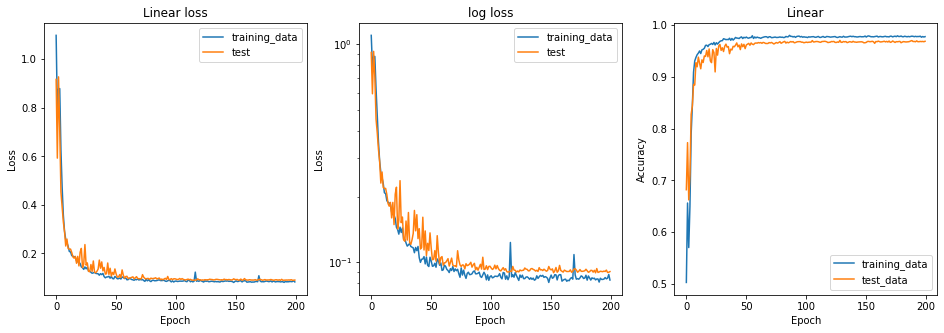

In [123]:
small_training_summary(training_history)
print('Final accuracy over the training set: {:.2f}%'.format(training_history['train_acc'][-1]*100))
print('Final accuracy over the validation set {:.2f}%'.format(training_history['val_acc'][-1]*100))
print('\n')
hc.evaluate_dataset(test_dl)